In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import Compose, Resize, ToTensor, ToPILImage 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from skimage import io
from tqdm import tqdm_notebook
from PIL import Image

In [2]:
import shutil

SIZE = 202599
TRAIN_SIZE = 20000
TEST_SIZE = 2000

for file in os.listdir('img_celeba/'):
    if int(file[:-4]) <= TRAIN_SIZE:
        shutil.copy2('img_celeba/'+file, 'images/train/'+file)
    if int(file[:-4]) > SIZE - TEST_SIZE:
        shutil.copy2('img_celeba/'+file, 'images/test/'+file)

In [3]:
def imshow(images):
    plt.figure(figsize=(15, 15))
    img = images
    img = torchvision.utils.make_grid(img)
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

In [4]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    points = np.array(val_history)
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()    

In [22]:
BATCH_SIZE = 16
IMG_SIZE = 128
MASK_SIZES = (16, 64)  # included
N_PRE_EPOCHS = 4
N_POST_EPOCHS = 2
N_BRANCHES = 2

In [6]:
transform = Compose([Resize((IMG_SIZE, IMG_SIZE)), ToTensor()])

class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.files = os.listdir(root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = os.path.join(self.root_dir, self.files[idx])
        image = Image.open(path)
        
        if self.transform:
            image = self.transform(image)
            image = image * 2 - 1
        
        mask_size = np.random.randint(MASK_SIZES[0], MASK_SIZES[1] + 1)
        loc_bounds = (0, IMG_SIZE - mask_size + 1)
        mask_x = np.random.randint(loc_bounds[0], loc_bounds[1])
        mask_y = np.random.randint(loc_bounds[0], loc_bounds[1])
        mask = torch.zeros(1, IMG_SIZE, IMG_SIZE, requires_grad=False)
        mask[:, mask_x : mask_x + mask_size, mask_y : mask_y + mask_size] = 1
        bbox = (mask_x, mask_x + mask_size, mask_y, mask_y + mask_size)

        return {'image':image, 'mask':mask, 'bbox':bbox}
    
train_dataset = CelebADataset('images/train/', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                        shuffle=False, num_workers=4, pin_memory=True)

test_dataset = CelebADataset('images/test/', transform=transform)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=4, pin_memory=True)

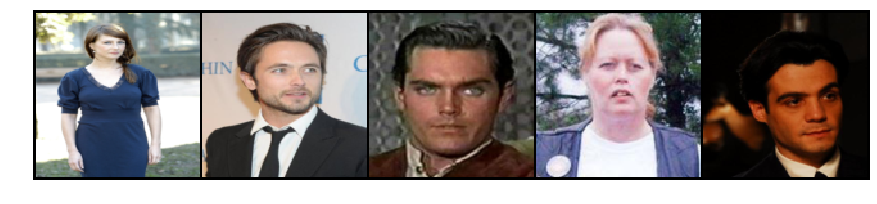

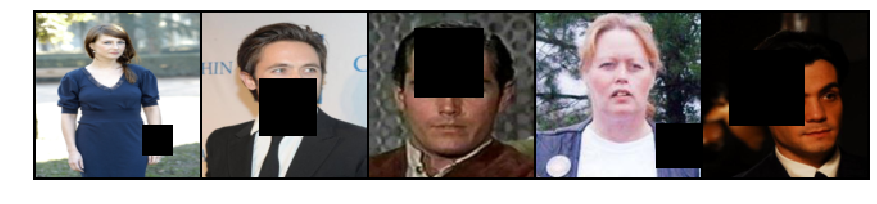

In [7]:
for i, batch in enumerate(train_loader):
    images = (batch['image']+ 1) / 2
    masks = batch['mask']
    imshow(images[:5])
    imshow(images[:5] * (1 - masks[:5]))
    break

In [8]:
class Identity(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x
    
    
class GeneratorBranch(nn.Module):
    def __init__(self, number):
        super().__init__()
        self.number = number
        k_size = number * 2 + 3
        n_ch = 32
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=n_ch, kernel_size=k_size + 2, \
                      stride=1, dilation=1, padding=(k_size - 1)//2 + 1),
            nn.ELU(),
            
            nn.Conv2d(in_channels=n_ch, out_channels=n_ch*2, kernel_size=k_size, \
                      stride=2, dilation=1, padding=(k_size - 1)//2),
            nn.ELU(),
            
            nn.Conv2d(in_channels=n_ch*2, out_channels=n_ch*2, kernel_size=k_size, \
                      stride=1, dilation=1, padding=(k_size - 1)//2),
            nn.ELU(),
            
            nn.Conv2d(in_channels=n_ch*2, out_channels=n_ch*4, kernel_size=k_size, \
                      stride=2, dilation=1, padding=(k_size - 1)//2),
            nn.ELU(),
            
            nn.Conv2d(in_channels=n_ch*4, out_channels=n_ch*4, kernel_size=k_size, \
                      stride=1, dilation=1, padding=(k_size - 1)//2),
            nn.ELU(),
            
            nn.Conv2d(in_channels=n_ch*4, out_channels=n_ch*4, kernel_size=k_size, \
                      stride=1, dilation=2, padding=2*(k_size - 1)//2),
            nn.ELU(),
            
            nn.Conv2d(in_channels=n_ch*4, out_channels=n_ch*4, kernel_size=k_size, \
                      stride=1, dilation=4, padding=4*(k_size - 1)//2),
            nn.ELU(),
            
            nn.Conv2d(in_channels=n_ch*4, out_channels=n_ch*4, kernel_size=k_size, \
                      stride=1, dilation=8, padding=8*(k_size - 1)//2),
            nn.ELU(),
            
        )
        if number == 0:
            self.upsample = nn.Sequential(
                nn.ConvTranspose2d(in_channels=n_ch*4, out_channels=n_ch*2, kernel_size=k_size, \
                                  stride=2, padding=(k_size - 1)//2, output_padding=1),
                nn.ELU(),
                nn.Conv2d(in_channels=n_ch*2, out_channels=n_ch*2, kernel_size=k_size, \
                         stride=1, padding=(k_size - 1)//2),
                nn.ELU(),
                nn.ConvTranspose2d(in_channels=n_ch*2, out_channels=n_ch, kernel_size=k_size, \
                                  stride=2, padding=(k_size - 1)//2, output_padding=1),
                nn.ELU()
            )
        elif number == 1:
            self.upsample = nn.Sequential(
                nn.ConvTranspose2d(in_channels=n_ch*4, out_channels=n_ch*2, kernel_size=k_size, \
                                  stride=2, padding=(k_size - 1)//2, output_padding=1),
                nn.ELU(),
                nn.Conv2d(in_channels=n_ch*2, out_channels=n_ch*2, kernel_size=k_size, \
                         stride=1, padding=(k_size - 1)//2),
                nn.ELU()
            )
        else:
            self.upsample = Identity()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.upsample(x)
        if self.number == 1:
            x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        elif self.number > 1:
            x = F.interpolate(x, scale_factor=4, mode='bilinear', align_corners=True)
        return x

In [9]:
class Generator(nn.Module):
    
    def __init__(self, n_branches):
        super().__init__()
        n_ch = 32
        self.n_branches = n_branches
        self.branches = nn.ModuleList([GeneratorBranch(i) for i in range(n_branches)])
        if n_branches == 1:
            in_ch = n_ch
        else:
            in_ch = 3*n_ch + (n_branches - 2) * 4 * n_ch
        self.decoder = nn.Sequential(
            nn.Conv2d(in_channels=in_ch, out_channels=in_ch//4, kernel_size=5, stride=1, padding=2),
            nn.ELU(),
            nn.Conv2d(in_channels=in_ch//4, out_channels=3, kernel_size=5, stride=1, padding=2),
        )
        
    def forward(self, x, mask):
        inp = torch.cat((x, mask), dim=1)
        feature_map = [branch(inp) for branch in self.branches]
        feature_map = torch.cat(feature_map, dim=1)
        out = self.decoder(feature_map)
        out = torch.clamp(out, -1, 1)
        return x + out * mask

In [10]:
def create_gauss(kernel_size=3, sigma=2, channels=3):
    x_coord = torch.arange(kernel_size, device='cuda')
    x_grid = x_coord.repeat(kernel_size).view(kernel_size, kernel_size)

    y_grid = x_grid.t()
    
    xy_grid = torch.stack([x_grid, y_grid], dim=-1).float()
    
    mean = (kernel_size - 1)/2.
    variance = sigma**2.

    weights = (1. / (2. * np.pi * variance)) * \
                       torch.exp(-torch.sum((xy_grid - mean)**2., dim=-1) / (2 * variance)
                      )
    
    weights = weights / torch.sum(weights)
    weights = weights.view(1, kernel_size, kernel_size)
    weights = weights.repeat(channels, 1, 1, 1)
    gfilter = nn.Conv2d(in_channels=channels, out_channels=channels,
                                kernel_size=kernel_size, bias=False, padding=(kernel_size - 1) // 2)
    gfilter.weight.data = weights
    return gfilter

gauss = create_gauss(33, 40, 1)

In [11]:
def smooth_mask(mask, n_gauss=5):
    with torch.no_grad():
        loss_mask = torch.zeros_like(mask, device='cuda', requires_grad=False)
        for j in range(n_gauss):
            loss_mask = 1 - mask + loss_mask
            loss_mask = gauss(loss_mask) * mask
    return loss_mask

In [12]:
def train_epoch(model, optimizer):
    loss_log = torch.zeros(len(train_loader), device='cuda')
    model.train()
    for i, batch in enumerate(tqdm_notebook(train_loader)):
        image = batch['image']
        mask = batch['mask']
        
        image = image.cuda()
        mask = mask.cuda()
            
        optimizer.zero_grad()        
        output = model(image * (1 - mask), mask)      
        
        loss_mask = smooth_mask(mask)
        
        loss = F.l1_loss(output * loss_mask, image * loss_mask) 
        loss.backward()
        optimizer.step()
        loss_log[i] = loss.detach()
    return loss_log   

def test(model):
    with torch.no_grad():
        loss_log = torch.zeros(len(test_loader), device='cuda')

        for batch_num, batch in enumerate(test_loader):    
            image = batch['image'].cuda()
            mask = batch['mask'].cuda()

            output = model(image * (1 - mask), mask)        

            loss_mask = smooth_mask(mask)

            loss = F.l1_loss(output * loss_mask, image * loss_mask) 
            loss_log[batch_num] = loss.detach()
    return loss_log

def train(model, opt, n_epochs):
    train_log = []
    val_log = []
    for epoch in range(n_epochs):
        train_loss = train_epoch(model, opt).tolist()
        torch.save(model.state_dict(), 'models/model_{:03d}.pt'.format(epoch + 1))
        val_loss = test(model).tolist()
        train_log.extend(train_loss)
        steps = len(train_loader)
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        clear_output()
        plot_history(train_log, val_log) 

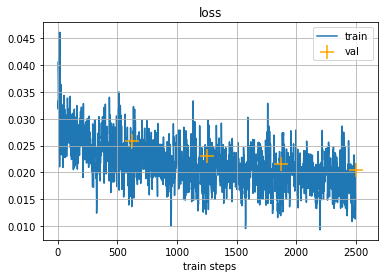

In [9]:
model = Generator(N_BRANCHES)
model.cuda()
opt = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.5, 0.9))

train(model, opt, N_PRE_EPOCHS)

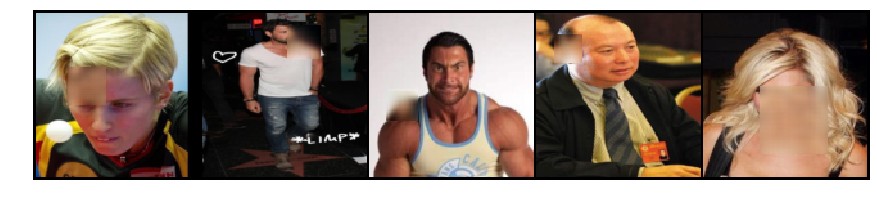

In [13]:
model = Generator(N_BRANCHES)
model.cuda()
model.load_state_dict(torch.load('models/model_{:03d}.pt'.format(N_PRE_EPOCHS)))

for b in test_loader:
    masks = b['mask'].cuda()
    images = b['image'].cuda()
    out = model(images * (1 - masks), masks)
    out = (out + 1) / 2
    imshow(out[5:10].detach())
    break

In [14]:
class LocalDistriminator(nn.Module):
    def __init__(self):
        super().__init__()
        n_ch = 32
        
        last_size = MASK_SIZES[1] // 16  # maximum possible size of a 'hole' at last conv
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=n_ch, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=n_ch, out_channels=n_ch*2, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=n_ch*2, out_channels=n_ch*4, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=n_ch*4, out_channels=n_ch*8, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            
        )
        self.classifier = nn.Linear(n_ch * 8 * last_size * last_size, 1)
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return torch.sigmoid(x)
    
class GlobalDistriminator(nn.Module):
    def __init__(self):
        super().__init__()
        n_ch = 32
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=n_ch, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=n_ch, out_channels=n_ch*2, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=n_ch*2, out_channels=n_ch*4, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=n_ch*4, out_channels=n_ch*4, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2)
        )
        last_size = IMG_SIZE // 16
        self.classifier = nn.Linear(4 * n_ch * last_size * last_size, 1)
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return torch.sigmoid(x)

In [15]:
from torch.nn.modules.distance import CosineSimilarity

PATCH_SIZE = 8


def id_mrf(filled, full):
    n_full = full.size()[2] // PATCH_SIZE
    n_filled = filled.size()[2] // PATCH_SIZE
    cosines = torch.zeros(BATCH_SIZE, n_filled**2, n_full**2)
    for i in range(n_full):
        for j in range(n_full):
            full_patch = full[:, :, i * PATCH_SIZE : (i + 1) * PATCH_SIZE, \
                             j * PATCH_SIZE : (j + 1) * PATCH_SIZE]
            full_patch = full_patch.contiguous().view(BATCH_SIZE, -1)
            for k in range(n_filled):
                for l in range(n_filled):
                    filled_patch = filled[:, :, k * PATCH_SIZE : (k + 1) * PATCH_SIZE, \
                             l * PATCH_SIZE : (l + 1) * PATCH_SIZE]
                    filled_patch = filled_patch.contiguous().view(BATCH_SIZE, -1)
                    dist = CosineSimilarity(dim=1)(full_patch, filled_patch)
                    cosines[:, k * n_filled + l,i * n_full + j] = dist
    max_cos = torch.max(cosines, dim=2)[0].view(BATCH_SIZE, -1, 1) + 1e-6
    cosines = cosines / max_cos
    cosines = torch.exp(cosines)
    cosines = cosines / cosines.sum(dim=2).view(BATCH_SIZE, -1, 1)
    loss = torch.max(cosines, dim=1)[0].sum(dim=1)
    
    return -torch.log(loss).mean()

In [16]:
def reconstruction_loss(output, target, mask=None):
    if mask is not None:
        loss = F.l1_loss(output * mask, target * mask)
    else:
        loss = F.l1_loss(output, target)
    return loss

def adversarial_loss(d_fakes, grads, mask, gp=10):
    loss = grads * mask
    loss = torch.norm(loss.view(loss.size()[0], -1), dim=1)
    loss = (gp * (loss - 1)**2).view(-1, 1)
    loss -= d_fakes
    return loss.mean()

def discriminator_loss(d_fakes, d_reals, grads, mask, gp=10):
    loss = grads * mask
    loss = torch.norm(loss.view(loss.size()[0], -1), dim=1)
    loss = (gp * (loss - 1)**2).view(-1, 1)
    loss += d_fakes - d_reals
    return loss.mean()

In [23]:
def crop(images, bboxes):
    result = torch.zeros(images.size()[0], 3, MASK_SIZES[1], MASK_SIZES[1], device='cuda')
    for i in range(result.size()[0]):
        a, b, c, d = bboxes[0][i], bboxes[1][i], bboxes[2][i], bboxes[3][i]
        img = images[i][:, a:b, c:d]
        img = nn.AdaptiveAvgPool2d(MASK_SIZES[1])(img)
        result[i] = img
    return result

In [24]:
from torchvision.models import vgg19

vgg = vgg19(True)
vgg.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [25]:
def train_epoch(gen, loc_disc, glob_disc, gen_opt, loc_opt, glob_opt, batchsize=32):
    loss_log = torch.zeros(len(train_loader), device='cuda')
    local_log = torch.zeros(len(train_loader), device='cuda')
    global_log = torch.zeros(len(train_loader), device='cuda')
    
    for i, batch in enumerate(tqdm_notebook(train_loader)):
        images = batch['image'].cuda()
        masks = batch['mask'].cuda()
        bboxes = batch['bbox']
        loss_masks = smooth_mask(masks)
        x = images * (1 - masks)
        
        gen_opt.zero_grad()        
        fakes = gen(x, masks)    
        cropped_fakes = crop(fakes, bboxes)
        
        t = torch.rand(x.size()[0], 1, 1, 1, device='cuda')
        x_mod = (t * fakes + (1 - t) * images).detach()
        x_mod.requires_grad = True
        
        loc_opt.zero_grad()
        loc_fakes = loc_disc(cropped_fakes) # pass only filled regions
        loc_reals = loc_disc(crop(images, bboxes))
        loc_mods = loc_disc(crop(x_mod, bboxes))
        loc_mods.sum().backward()
        loc_grads = x_mod.grad.data
        #x_mod.zero_grad()
        
        glob_opt.zero_grad()
        glob_fakes = glob_disc(fakes)  # pass whole images
        glob_reals = glob_disc(images)
        glob_mods = glob_disc(x_mod)
        glob_mods.sum().backward()
        glob_grads = x_mod.grad.data
        
        loc_loss = discriminator_loss(loc_fakes, loc_reals, loc_grads, loss_masks)
        loc_loss.backward(retain_graph=True)
        loc_opt.step()
        
        glob_loss = discriminator_loss(glob_fakes, glob_reals, glob_grads, loss_masks)
        glob_loss.backward(retain_graph=True)
        glob_opt.step()
        
        adv_loss = adversarial_loss(loc_fakes, loc_grads, loss_masks) + \
                          adversarial_loss(glob_fakes, glob_grads, loss_masks)
        rec_loss = reconstruction_loss(fakes, images, loss_masks)
        
        with torch.no_grad():
            mrf_loss = 0
            for n in [14, 23]:
                full = vgg.features[:n](images)
                filled = vgg.features[:n](cropped_fakes)
                mrf_loss += id_mrf(filled, full)
        
        loss = rec_loss + 5e-4 * adv_loss + 0.05 * mrf_loss
        loss.backward()
        gen_opt.step()
        
        local_log[i] = loc_loss.detach()
        global_log[i] = glob_loss.detach()
        loss_log[i] = loss.detach()
    return loss_log.tolist(), local_log.tolist(), global_log.tolist()

def test(gen, loc_disc, glob_disc):
    loss_log = torch.zeros(len(test_loader), device='cuda')
    local_log = torch.zeros(len(test_loader), device='cuda')
    global_log = torch.zeros(len(test_loader), device='cuda')
    
    for batch_num, batch in enumerate(test_loader):    
        images = batch['image'].cuda()
        masks = batch['mask'].cuda()
        bboxes = batch['bbox']
        loss_masks = smooth_mask(masks)
        x = images * (1 - masks)
        
        with torch.no_grad():   
            fakes = gen(x, masks)
            cropped_fakes = crop(fakes, bboxes)
        
        t = torch.rand(x.size()[0], 1, 1, 1, device='cuda')
        x_mod = (t * fakes + (1 - t) * images).detach()
        x_mod.requires_grad = True
        
        with torch.no_grad():
            loc_fakes = loc_disc(cropped_fakes) # pass only filled regions
            loc_reals = loc_disc(crop(images, bboxes))
        loc_mods = loc_disc(crop(x_mod, bboxes))
        loc_mods.sum().backward()
        loc_grads = x_mod.grad.data
        
        with torch.no_grad():
            glob_fakes = glob_disc(fakes)  # pass whole images
            glob_reals = glob_disc(images)
        glob_mods = glob_disc(x_mod)
        glob_mods.sum().backward()
        glob_grads = x_mod.grad.data
        
        loc_loss = discriminator_loss(loc_fakes, loc_reals, loc_grads, loss_masks)
        
        glob_loss = discriminator_loss(glob_fakes, glob_reals, glob_grads, loss_masks)
        
        adv_loss = adversarial_loss(loc_fakes, loc_grads, loss_masks) + \
                          adversarial_loss(glob_fakes, glob_grads, loss_masks)
        
        rec_loss = reconstruction_loss(fakes, images, loss_masks)
        
        with torch.no_grad():
            mrf_loss = 0
            for n in [14, 23]:
                full = vgg.features[:n](images)
                filled = vgg.features[:n](cropped_fakes)
                mrf_loss += id_mrf(filled, full)
                
        loss = rec_loss + 5e-4 * adv_loss + 0.05 * mrf_loss
        
        loss_log[batch_num] = loss.detach()
        local_log[batch_num] = loc_loss.detach()
        global_log[batch_num] = glob_loss.detach()
    return loss_log.tolist(), local_log.tolist(), global_log.tolist()

    
def train(gen, loc_disc, glob_disc, gen_opt, loc_opt, glob_opt, n_epochs):
    tgen_log = []
    tloc_log = []
    tglob_log = []
    vgen_log = []
    vloc_log = []
    vglob_log = []
    for epoch in range(n_epochs):
        tgen_loss, tlocal_loss, tglobal_loss = train_epoch(gen, loc_disc, glob_disc, \
                                 gen_opt, loc_opt, glob_opt, batchsize=BATCH_SIZE)
        
        torch.save(gen.state_dict(), 'models/gen_{:03d}.pt'.format(epoch + 1))
        torch.save(loc_disc.state_dict(), 'models/loc_{:03d}.pt'.format(epoch + 1))
        torch.save(glob_disc.state_dict(), 'models/glob_{:03d}.pt'.format(epoch + 1))
        
        tgen_log.extend(tgen_loss)
        tloc_log.extend(tlocal_loss)
        tglob_log.extend(tglobal_loss)
        
        vgen_loss, vlocal_loss, vglobal_loss = test(gen, loc_disc, glob_disc)
        steps = len(train_loader)
        
        vgen_log.append((steps * (epoch + 1), np.mean(vgen_loss)))
        vloc_log.append((steps * (epoch + 1), np.mean(vlocal_loss)))
        vglob_log.append((steps * (epoch + 1), np.mean(vglobal_loss)))
        
        clear_output()
        plot_history(tgen_log, vgen_log, 'generator') 
        plot_history(tloc_log, vloc_log, 'local disc') 
        plot_history(tglob_log, vglob_log, 'global disc') 

In [26]:
gen = Generator(N_BRANCHES)
gen.cuda()
gen.load_state_dict(torch.load('models/model_{:03d}.pt'.format(N_PRE_EPOCHS)))
gen_opt = torch.optim.Adam(gen.parameters(), lr=1e-4, betas=(0.5, 0.9))

loc_disc = LocalDistriminator()
loc_disc.cuda()
loc_opt = torch.optim.Adam(loc_disc.parameters(), lr=1e-4, betas=(0.5, 0.9))

glob_disc = GlobalDistriminator()
glob_disc.cuda()
glob_opt = torch.optim.Adam(glob_disc.parameters(), lr=1e-4, betas=(0.5, 0.9))

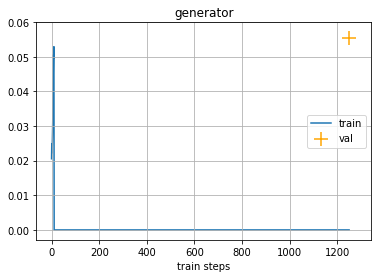

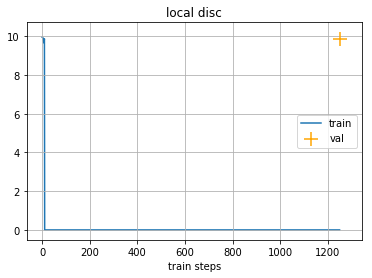

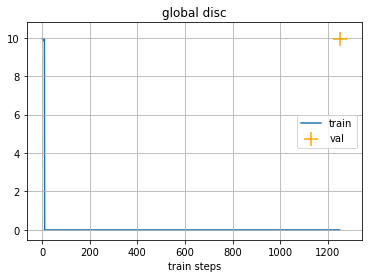

Traceback (most recent call last):
  File "/data/anaconda/envs/py35/lib/python3.5/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/data/anaconda/envs/py35/lib/python3.5/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/data/anaconda/envs/py35/lib/python3.5/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/data/anaconda/envs/py35/lib/python3.5/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/data/anaconda/envs/py35/lib/python3.5/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/data/anaconda/envs/py35/lib/python3.5/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/data/anaconda/envs/py35/lib/python3.5/multiprocessing/connection.py", line 404, in _send_by

KeyboardInterrupt: 

In [27]:
train(gen, loc_disc, glob_disc, gen_opt, loc_opt, glob_opt, N_POST_EPOCHS)

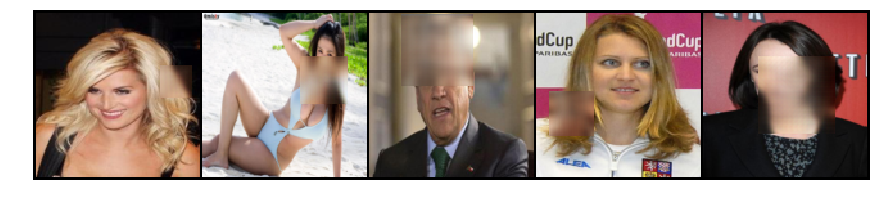

In [23]:
gen.load_state_dict(torch.load('models/gen_{:03d}.pt'.format(N_POST_EPOCHS)))

for b in test_loader:
    masks = b['mask'].cuda()
    images = b['image'].cuda()
    out = gen(images * (1 - masks), masks)
    out = (out + 1) / 2
    imshow(out[5:10].detach())
    break